In [1]:
""" Import libraries. """
import os
from pathlib import Path

output_dir = Path("outputs").resolve()
if not output_dir.exists():
    output_dir.mkdir(exist_ok=False)
    print(f"Making output directory: {output_dir}")
else:
    print(f"Using extant output directory: {output_dir}")
from dotenv import load_dotenv

load_dotenv();  # TODO: make common example prep function

from earth2studio.data import GFS
from earth2studio.io import XarrayBackend
from earth2studio.models.px import SFNO
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import earth2studio.run as run
cache_loc = os.environ["EARTH2STUDIO_CACHE"]
print(f"Earth2Studio cache: {cache_loc}")

Using extant output directory: /glade/work/jmelms/data/e2s_outputs


/glade/u/home/jmelms/projects/earth2studio_setup/earth2studio-project/.venv/lib/python3.12/site-packages/ngcbase/util/utils.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Earth2Studio cache: /glade/work/jmelms/software/.E2S_cache


In [2]:
from datetime import datetime
from earth2studio.utils.type import TimeArray, VariableArray
import xarray as xr

class DataSetFile:
    """A local xarray dataset file data source. This file should be compatable with
    xarray. For example, a netCDF file.

    Parameters
    ----------
    file_path : str
        Path to xarray dataset compatible file.
    array_name : str
        Data array name in xarray dataset
    """

    def __init__(self, file_path: str, **xr_args ):
        self.file_path = file_path
        self.ds = xr.open_dataset(self.file_path, **xr_args)

    def __call__(
        self,
        time: datetime | list[datetime] | TimeArray,
        variable: str | list[str] | VariableArray,
    ) -> xr.DataArray:
        """Function to get data.

        Parameters
        ----------
        time : datetime | list[datetime] | TimeArray
            Timestamps to return data for.
        variable : str | list[str] | VariableArray
            Strings or list of strings that refer to variables to return.

        Returns
        -------
        xr.DataArray
            Loaded data array
        """
        # loop over variables and concatenate the data arrays
        da_list = [self.ds[v].sel(time=np.atleast_1d(time)) for v in variable]
        da = xr.concat(da_list, dim="variable")
        da = da.assign_coords(variable=variable)
        # reorder to time variable lat lon
        da = da.transpose("time", "variable", "lat", "lon")
        return da

In [11]:
""" Set up the model """
# Load the default model package which downloads the check point from NGC
package = SFNO.load_default_package()
model = SFNO.load_model(package)

In [3]:
""" Set up the data sources. """
unperturbed_data = DataSetFile('initial_conditions/ic_unperturbed.nc')
perturbed_data = DataSetFile('initial_conditions/ic_perturbed.nc')

In [4]:
""" Set up tendency reversion. """
# set up IO
dummy_io = XarrayBackend()

# set up a hook function that appends the model state to a list
states = []
def append_state(x, coords):
    """ Appends the states to a list"""
    states.append(x)
    return x, coords

model.rear_hook = append_state
model.front_hook = append_state

# run the model for one step; this will populate the states[] list above
nsteps = 1
io = run.deterministic(["2024-01-01"], nsteps, model, unperturbed_data, dummy_io)

# get the recurrent perturbation
rpert = states[0] - states[1]

NameError: name 'model' is not defined

2025-06-11 12:50:48.345 | INFO     | earth2studio.run:deterministic:75 - Running simple workflow!
2025-06-11 12:50:48.346 | INFO     | earth2studio.run:deterministic:82 - Inference device: cuda
2025-06-11 12:50:49.410 | SUCCESS  | earth2studio.run:deterministic:106 - Fetched data from DataSetFile
2025-06-11 12:50:50.030 | INFO     | earth2studio.run:deterministic:136 - Inference starting!


Running inference: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


2025-06-11 12:50:52.510 | SUCCESS  | earth2studio.run:deterministic:146 - Inference complete
<xarray.Dataset> Size: 584B
Dimensions:  ()
Data variables: (12/73)
    u10m     float64 8B 1.907e-06
    v10m     float64 8B 1.907e-06
    u100m    float64 8B 1.907e-06
    v100m    float64 8B 1.907e-06
    t2m      float64 8B 0.0
    sp       float64 8B 0.0
    ...       ...
    q500     float64 8B 2.328e-10
    q600     float64 8B 4.657e-10
    q700     float64 8B 4.657e-10
    q850     float64 8B 9.313e-10
    q925     float64 8B 1.863e-09
    q1000    float64 8B 1.863e-09


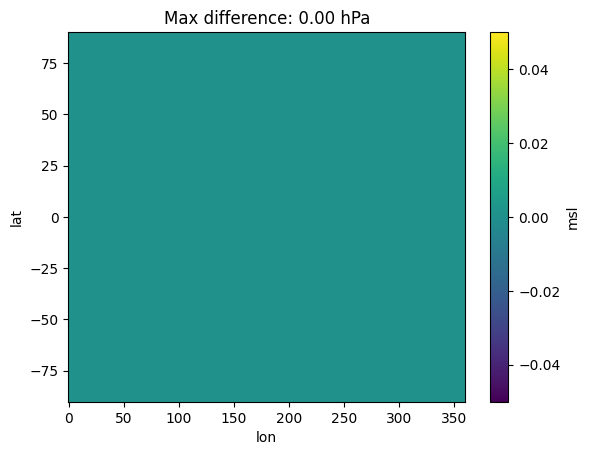

In [ ]:
""" Verify that tendency reversion works. """

# set up a post-model hook function that reverts the tendency
def tendency_reversion(x, coords):
    """ Reverts the tendency to the first state """
    return x + rpert, coords

# set up a hook function that returns the input as is
def identity(x, coords):
    """ Returns the input as is """
    return x, coords

# reset the model hooks
model.front_hook = identity
model.rear_hook = tendency_reversion

nsteps = 1
io = XarrayBackend()
io = run.deterministic(["2024-01-01"], nsteps, model, unperturbed_data, io)
ds = io.root

# plot the difference between the timesteps
ds_diff = ds.diff(dim = "lead_time")
ds_diff['msl'].plot()
plt.title(f"Max difference: {ds_diff['msl'].max().values:.2f} hPa")
print(ds_diff.max())

In [ ]:
""" Run the model with the perturbed data and tendency reversion. """

# reset the model hooks for tendency reversion
model.front_hook = identity
model.rear_hook = tendency_reversion

nsteps = 10 * 4 # steps, 10 days at 4 steps per day
io = XarrayBackend()
io = run.deterministic(["2024-01-01"], nsteps, model, perturbed_data, io)

2025-06-11 12:50:57.364 | INFO     | earth2studio.run:deterministic:75 - Running simple workflow!
2025-06-11 12:50:57.365 | INFO     | earth2studio.run:deterministic:82 - Inference device: cuda
2025-06-11 12:50:58.143 | SUCCESS  | earth2studio.run:deterministic:106 - Fetched data from DataSetFile
2025-06-11 12:51:04.238 | INFO     | earth2studio.run:deterministic:136 - Inference starting!


Running inference: 100%|██████████| 41/41 [01:07<00:00,  1.64s/it]

2025-06-11 12:52:11.339 | SUCCESS  | earth2studio.run:deterministic:146 - Inference complete


In [ ]:
ds = io.root
import os
os.makedirs("outputs", exist_ok=True)
ds.to_netcdf("outputs/perturbed.nc")

: 

: 

: 